### 4.2. Who should get a bank credit?
The German credit data set from the UCI data set library (http://archive.ics.uci.edu/ml/index.html) describes the customers of a bank with respect to whether they should get a bank credit or not. The data set is provided as credit-g.arff file in ILIAS. 

#### 4.2.1. Plot ROC curves for k-NN (different k values) and Decision Tree (you can use the given avg_roc function) . Which classification approach looks most promising to you?

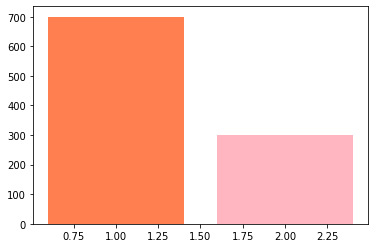

In [249]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter


names=[('Attribute '+str(i)) for i in range(1,21)]
names.append('class')
credit = pd.read_csv("german.data",sep=' ',header=None,names=names)
credit.head()

# separate the target variable from the features
credit_target = credit['class']

credit_data = credit.drop('class', axis=1)

# plot the class distribution
c = ['good','bad']
counter = Counter(credit_target)
plt.bar(counter.keys(), counter.values(),color=['coral','lightpink'])
plt.show()

In [250]:
for i in credit_target.values:
    if i == 2:
        credit_target.replace(i,0,inplace=True)

In [251]:
credit_data.select_dtypes(include=['int64', 'float64']).columns

Index(['Attribute 2', 'Attribute 5', 'Attribute 8', 'Attribute 11',
       'Attribute 13', 'Attribute 16', 'Attribute 18'],
      dtype='object')

In [252]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# think about which features you want to re-scale, encode using one-hot encoding or encode using ordinal encoding
# then, create a ColumnTransformer to execute this preprocessing for you
cat_ix = credit_data.select_dtypes(include=['object', 'bool']).columns
num_ix = credit_data.select_dtypes(include=['int64', 'float64']).columns

# one hot encode cat features only
preprocessor = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',StandardScaler(),num_ix)])

Run the following cell once to define the ```avg_roc``` function:

In [253]:
#define function for computing average roc for cross validation
#see http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
from scipy import interp
from sklearn.metrics import roc_curve, auc

def avg_roc(cv, estimator, data, target,classifier):
    print(estimator['estimator'])

    mean_fpr = np.linspace(0, 1, 100) # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []
    for train_indices, test_indices in cv.split(data, target):
        train_data = data.iloc[train_indices]
        train_target = target[train_indices]
        estimator.fit(train_data, train_target)
        test_data = data.iloc[test_indices]
        test_target = target[test_indices]
        decision_for_each_class = estimator.predict_proba(test_data)
    
        fpr, tpr, thresholds = roc_curve(test_target, decision_for_each_class[:,1]) #, pos_label=pos_label
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # tprs[-1] access the last element
        aucs.append(auc(fpr, tpr))
        if(classifier==KNeighborsClassifier):
            plt.plot(fpr, tpr)# plot for each fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

The evaluate different classifiers using the ```avg_roc``` function and plot the results:

KNeighborsClassifier()
KNeighborsClassifier()
KNeighborsClassifier()
KNeighborsClassifier()
KNeighborsClassifier()
DecisionTreeClassifier()
GaussianNB()


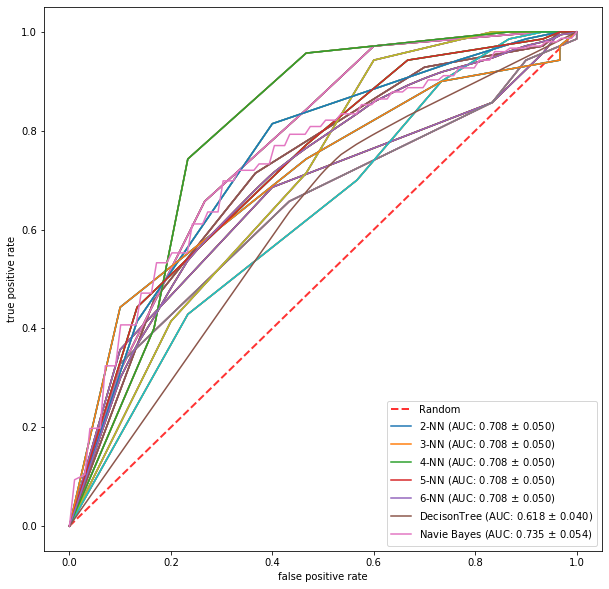

In [270]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# define the cross validation folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
classifier = KNeighborsClassifier()
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', classifier) ])
# setup a figure
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8) # draw diagonal

# KNN
for n_neighbour in [2,3,4,5,6]:
    #TODO: INSERT YOUR CODE HERE!
    mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, credit_data, credit_target,KNeighborsClassifier)
    plt.plot(mean_fpr, mean_tpr, label='{}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(n_neighbour, mean_auc, std_auc))

# Decision Tree
classifier = DecisionTreeClassifier()
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', classifier) ])
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, credit_data,credit_target,DecisionTreeClassifier)
plt.plot(mean_fpr, mean_tpr, label='DecisonTree (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))

# Naive Bayes
classifier = GaussianNB()
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', classifier) ])
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, credit_data,credit_target,GaussianNB)
plt.plot(mean_fpr, mean_tpr, label='Navie Bayes (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))


# show the plot
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

#### 4.2.2.	For the two most promising classification approaches, compute the accuracy and confusion matrix in a 10-fold CV setup. Which level of accuracy do you reach?

In [222]:
'''
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
'''

'\nimport itertools\ndef plot_confusion_matrix(cm, classes,\n                          normalize=False,\n                          title=\'Confusion matrix\',\n                          cmap=plt.cm.Blues):\n    """\n    This function prints and plots the confusion matrix.\n    Normalization can be applied by setting `normalize=True`.\n    """\n    if normalize:\n        cm = cm.astype(\'float\') / cm.sum(axis=1)[:, np.newaxis]\n\n    plt.imshow(cm, interpolation=\'nearest\', cmap=cmap)\n    plt.title(title)\n    plt.colorbar()\n    tick_marks = np.arange(len(classes))\n    plt.xticks(tick_marks, classes, rotation=45)\n    plt.yticks(tick_marks, classes)\n\n    fmt = \'.2f\' if normalize else \'d\'\n    thresh = cm.max() / 2.\n    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):\n        plt.text(j, i, format(cm[i, j], fmt),\n                 horizontalalignment="center",\n                 color="white" if cm[i, j] > thresh else "black")\n\n    plt.ylabel(\'True la

In [337]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix

# define the cross validation folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(credit_data,credit_target,stratify=credit_target,test_size=0.2,random_state=1)

accuracy 0.67


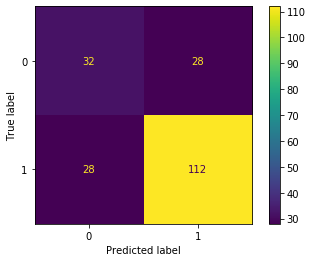

In [338]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', DecisionTreeClassifier()) ])
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=10)

pipeline.fit(X_train,y_train)
plot_confusion_matrix(pipeline,X_test,y_test)


predY = pipeline.predict(X_test)
print('accuracy',scores.mean())

accuracy 0.7337499999999999


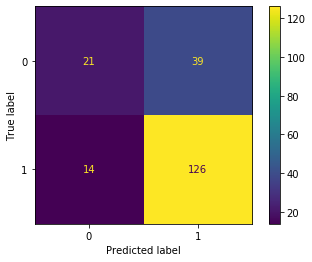

In [339]:
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', KNeighborsClassifier()) ])
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=10)

pipeline.fit(X_train,y_train)
plot_confusion_matrix(pipeline,X_test,y_test)

predY = pipeline.predict(X_test)
print('accuracy',scores.mean())

accuracy 0.49375


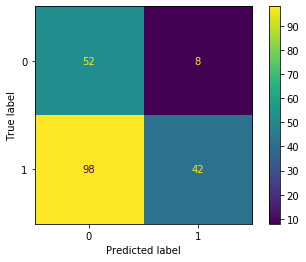

In [340]:
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', GaussianNB()) ])
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=10)

pipeline.fit(X_train,y_train)
plot_confusion_matrix(pipeline,X_test,y_test)

predY = pipeline.predict(X_test)
print('accuracy',scores.mean())

#### 4.2.3.	What do the precision and recall values for the class “bad”  tell you? Try to improve the situation by increasing the number of “bad” examples in the training set (in the cross validation). How do precision and recall change if you apply this procedure? 

In [348]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

credit_target.value_counts() # 1: 'good', 0: 'bad'

1    700
0    300
Name: class, dtype: int64

In [350]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

sm = RandomOverSampler()

X_resampled, y_resampled = sm.fit_resample(credit_data,credit_target)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_resampled,y_resampled,stratify=y_resampled,test_size=0.2,random_state=1)

y_resampled.value_counts()

1    700
0    700
Name: class, dtype: int64

accuracy 0.8080357142857142


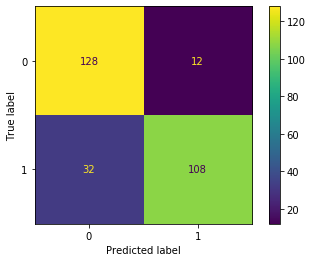

In [351]:
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', DecisionTreeClassifier()) ])
scores = cross_val_score(pipeline,X_train1 , y_train1, scoring='accuracy', cv=10)

pipeline.fit(X_train1,y_train1)
plot_confusion_matrix(pipeline,X_test1,y_test1)

predY = pipeline.predict(X_test1)
print('accuracy',scores.mean())

accuracy 0.7169642857142857


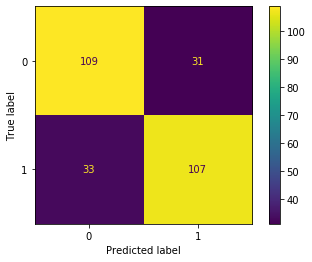

In [352]:

pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', KNeighborsClassifier()) ])
scores = cross_val_score(pipeline,X_train1 , y_train1, scoring='accuracy', cv=10)

pipeline.fit(X_train1,y_train1)
plot_confusion_matrix(pipeline,X_test1,y_test1)

predY = pipeline.predict(X_test1)
print('accuracy',scores.mean())

accuracy 0.7008928571428572


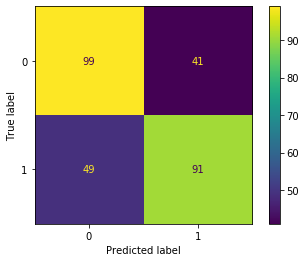

In [353]:
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', GaussianNB()) ])
scores = cross_val_score(pipeline,X_train1 , y_train1, scoring='accuracy', cv=10)

pipeline.fit(X_train1,y_train1)
plot_confusion_matrix(pipeline,X_test1,y_test1)

predY = pipeline.predict(X_test1)
print('accuracy',scores.mean())

#### 4.2.4.	To model a use case specific evaluation, compute the cost of all missclassifications. Set up your cost matrix by assuming that you will lose 1 Unit if you refuse a credit to a good customer, but that you lose 100 Units if you give a bad customer a credit. Rerun the experiments and evaluate the results.

In [ ]:
from sklearn.metrics import confusion_matrix

# create the predictions here
# prediction = ...

# You can use the following code to calculate the cost
cm = confusion_matrix(credit_target, prediction, labels=credit_target.unique())
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(credit_target, prediction)
print("6-NN with accuracy of {} and cost {}".format(acc, cost))

#### 4.2.5.	As the creation of training data is mostly a manual task and humans tend to be fallible, training data might include noise. Simulate this behavior by using the Add Noise function and change the parameter “percentage” from 0% over 10% to 20%. Is your preferred classification approach still feasible for this situation? How does the performance of the other classifiers evolve?

In [ ]:
import random 
from sklearn.utils.multiclass import unique_labels
def add_noise(raw_target, percentage):    
    labels = unique_labels(raw_target)
    target_with_noise = []
    for one_target_label in raw_target:
        if random.randint(1,100) <= percentage:
            target_with_noise.append(next(l for l in labels if l != one_target_label))
        else:
            target_with_noise.append(one_target_label)
    return target_with_noise

In [ ]:
# TODO: add noise to your training splits and evaluate (e.g. use manual cross validation (see intro slides) for this)